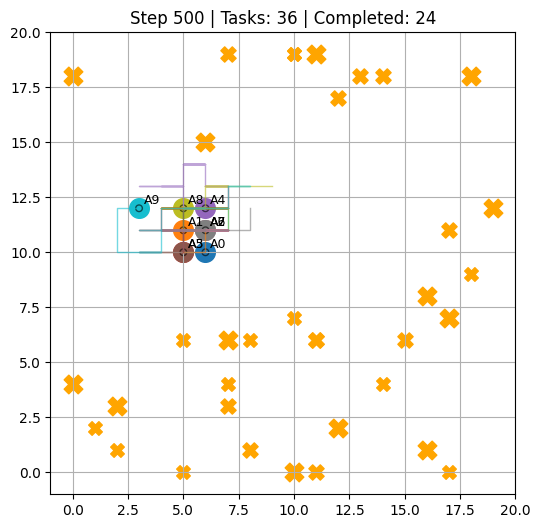

Simulation complete.
Metrics: {'task_completed': 24, 'collisions': 1255, 'comm_overhead': 4086}


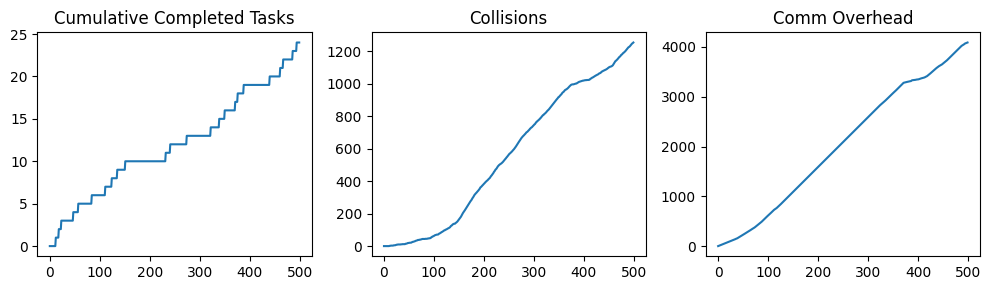

In [19]:
# Autonomous Multi-Agent Collaboration (research-paper-matching, lightweight)
# Paste this whole block into a single Colab cell and run.

import random, math, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ----------------------
# SETTINGS (change these)
# ----------------------
GRID_SIZE = 20            # environment is GRID_SIZE x GRID_SIZE
NUM_AGENTS = 10           # default number of agents
STEPS = 500               # simulation steps
INITIAL_TASKS = 8
TASK_SPAWN_PROB = 0.40    # probability of new task each step
OBS_RANGE = 5             # how far an agent perceives (Manhattan)
COMM_THRESHOLD = 2        # if visible tasks > threshold, agent broadcasts
SWARM_COEF = {'cohesion':0.02, 'separation':0.25, 'alignment':0.03}
ENERGY_COST_PER_MOVE = 0.01
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ----------------------
# Helper functions
# ----------------------
def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def clamp(x, a, b): return max(a, min(b, x))

# ----------------------
# Task class
# ----------------------
class Task:
    def __init__(self, x, y, priority=1.0, lifetime=200):
        self.pos = (x,y)
        self.priority = priority  # higher = more important
        self.lifetime = lifetime  # steps before disappearing

# ----------------------
# Agent class (per paper mapping)
# ----------------------
class Agent:
    def __init__(self, aid):
        self.id = aid
        self.x = random.randint(0, GRID_SIZE-1)
        self.y = random.randint(0, GRID_SIZE-1)
        self.target = None        # (x,y)
        self.energy = 1.0         # normalized
        self.capability = random.uniform(0.7,1.0)  # heterogeneous agents
        # preference weights for utility: [alpha (distance), beta (capability), gamma (priority), delta (energy cost)]
        self.weights = np.array([-2.0, 1.0, 1.2, -0.4])
        self.recent_reward = 0.0
        self.comm_count = 0       # messages broadcast (for overhead metric)
        self.path = [(self.x,self.y)]

    def observe(self, world_tasks, other_agents):
        # partial observability: tasks and agents within OBS_RANGE (Manhattan)
        visible_tasks = [t for t in world_tasks if manhattan((self.x,self.y), t.pos) <= OBS_RANGE]
        visible_agents = [a for a in other_agents if manhattan((self.x,self.y), (a.x,a.y)) <= OBS_RANGE and a.id != self.id]
        return visible_tasks, visible_agents

    def compute_utility(self, task):
        # utility Ut = alpha * (-distance) + beta*capability + gamma*priority + delta*(-energy)
        dist = manhattan((self.x,self.y), task.pos)
        features = np.array([-dist, self.capability, task.priority, -self.energy])
        return float(np.dot(self.weights, features))

    def choose_task(self, visible_tasks, shared_tasks_from_comm):
        # Combine local visible tasks and communicated tasks (if any)
        candidates = visible_tasks[:]
        # Add tasks learned from communication (if not duplicate)
        for t in shared_tasks_from_comm:
            if all(manhattan(t.pos, vt.pos) != 0 for vt in candidates):
                candidates.append(t)
        if not candidates:
            self.target = None
            return None
        best = max(candidates, key=lambda tt: self.compute_utility(tt))
        self.target = best.pos
        return self.target

    def step_towards_target(self):
        if not self.target:
            return False
        tx, ty = self.target
        # movement influenced by simple swarm rule adjustment applied externally (so agent only picks cardinal step for now)
        dx = 0
        dy = 0
        if self.x < tx: dx = 1
        elif self.x > tx: dx = -1
        elif self.y < ty: dy = 1
        elif self.y > ty: dy = -1

        # move
        self.x = clamp(self.x + dx, 0, GRID_SIZE-1)
        self.y = clamp(self.y + dy, 0, GRID_SIZE-1)
        self.energy = max(0.0, self.energy - ENERGY_COST_PER_MOVE)
        self.path.append((self.x,self.y))
        # reached?
        if (self.x, self.y) == (tx, ty):
            self.target = None
            return True
        return False

    def broadcast_needed(self, visible_tasks):
        # Adaptive communication: broadcast if local uncertainty is high
        if len(visible_tasks) >= COMM_THRESHOLD:
            self.comm_count += 1
            return True
        return False

    def adjust_weights(self, reward, lr=0.05):
        # Simple reward-driven hill-climb: increase weights that favor the outcome
        self.recent_reward = reward
        # update proportional to reward and observed features average:
        # small random perturbation weighted by reward
        noise = np.random.normal(scale=0.03, size=self.weights.shape)
        self.weights += lr * reward * noise
        # keep weights bounded for stability
        self.weights = np.clip(self.weights, -5, 5)

# ----------------------
# Environment class
# ----------------------
class Environment:
    def __init__(self, n_agents=NUM_AGENTS):
        self.agents = [Agent(i) for i in range(n_agents)]
        self.tasks = []
        # metrics
        self.metrics = {'task_completed':0, 'collisions':0, 'comm_overhead':0}
        self.step_count = 0

    def spawn_task(self):
        if random.random() < TASK_SPAWN_PROB:
            tx = random.randint(0, GRID_SIZE-1)
            ty = random.randint(0, GRID_SIZE-1)
            pr = random.choice([0.8, 1.0, 1.5])  # varying priorities
            self.tasks.append(Task(tx, ty, priority=pr, lifetime=200))

    def decay_tasks(self):
        for t in self.tasks[:]:
            t.lifetime -= 1
            if t.lifetime <= 0:
                self.tasks.remove(t)

    def step(self):
        self.step_count += 1
        # spawn & decay tasks
        self.spawn_task()
        self.decay_tasks()

        # perception & communication phase
        global_comm_tasks = []  # tasks shared this step
        for a in self.agents:
            visible_tasks, visible_agents = a.observe(self.tasks, self.agents)
            if a.broadcast_needed(visible_tasks):
                # broadcast visible tasks to global_comm_tasks (adaptive comm)
                global_comm_tasks.extend(visible_tasks)
        # update comm metric
        self.metrics['comm_overhead'] += sum(a.comm_count for a in self.agents)
        # reset per-agent comm_count since we aggregated (prevents double counting across steps)
        for a in self.agents:
            a.comm_count = 0

        # decision: assign targets based on utilities & simple local negotiation
        # To avoid duplicate targeting, we'll let each agent choose sequentially and mark tasks as "claimed"
        claimed = set()
        # shuffle order to avoid static priority
        idx_order = list(range(len(self.agents)))
        random.shuffle(idx_order)
        for idx in idx_order:
            agent = self.agents[idx]
            visible_tasks, visible_agents = agent.observe(self.tasks, self.agents)
            # filter out already claimed tasks
            visible_tasks = [t for t in visible_tasks if t.pos not in claimed]
            # include commun tasks but avoid duplicates
            shared = [t for t in global_comm_tasks if t.pos not in claimed]
            chosen = agent.choose_task(visible_tasks, shared)
            if chosen:
                claimed.add(chosen)

        # apply swarm motion offsets (cohesion, separation, alignment)
        self.apply_swarm_rules()

        # movement & task completion
        for agent in self.agents:
            completed = agent.step_towards_target()
            if completed:
                # find task object and score reward
                done_task = next((t for t in self.tasks if t.pos == (agent.x,agent.y)), None)
                if done_task:
                    # reward is combination of priority and remaining energy
                    reward = done_task.priority * (0.5 + agent.energy*0.5)
                    agent.adjust_weights(reward)
                    self.metrics['task_completed'] += 1
                    try:
                        self.tasks.remove(done_task)
                    except ValueError:
                        pass

        # collisions: if two agents share same cell -> count and apply small penalty
        positions = {}
        for a in self.agents:
            positions.setdefault((a.x,a.y), []).append(a)
        for pos,alist in positions.items():
            if len(alist) > 1:
                # collision occurred
                self.metrics['collisions'] += (len(alist)-1)
                # small energy penalty & small negative reward to participants
                for a in alist:
                    a.energy = max(0.0, a.energy - 0.05)
                    a.adjust_weights(-0.2)

    def apply_swarm_rules(self):
        # for each agent compute small motion offset from swarm rules: cohesion, separation, alignment
        for a in self.agents:
            visible_agents = [b for b in self.agents if b.id != a.id and manhattan((a.x,a.y),(b.x,b.y))<=OBS_RANGE]
            if not visible_agents:
                continue
            # cohesion: move toward average position
            avg_x = sum(b.x for b in visible_agents)/len(visible_agents)
            avg_y = sum(b.y for b in visible_agents)/len(visible_agents)
            coh_dx = clamp(round(np.sign(avg_x - a.x) * SWARM_COEF['cohesion']), -1, 1)
            coh_dy = clamp(round(np.sign(avg_y - a.y) * SWARM_COEF['cohesion']), -1, 1)

            # separation: avoid too-close agents
            sep_dx = 0; sep_dy = 0
            for b in visible_agents:
                if manhattan((a.x,a.y),(b.x,b.y)) <= 1:
                    sep_dx += a.x - b.x
                    sep_dy += a.y - b.y
            sep_dx = clamp(int(np.sign(sep_dx) * SWARM_COEF['separation']), -1, 1)
            sep_dy = clamp(int(np.sign(sep_dy) * SWARM_COEF['separation']), -1, 1)

            # alignment: match the average heading (we approximate heading by last two positions if available)
            align_dx = 0; align_dy = 0
            headings = []
            for b in visible_agents:
                if len(b.path) >= 2:
                    hx = b.path[-1][0] - b.path[-2][0]
                    hy = b.path[-1][1] - b.path[-2][1]
                    headings.append((hx,hy))
            if headings:
                mean_hx = sum(h[0] for h in headings)/len(headings)
                mean_hy = sum(h[1] for h in headings)/len(headings)
                align_dx = clamp(round(np.sign(mean_hx) * SWARM_COEF['alignment']), -1, 1)
                align_dy = clamp(round(np.sign(mean_hy) * SWARM_COEF['alignment']), -1, 1)

            # combine the small offsets - apply as micro-adjustment to target (if exists) by shifting target influence
            # We implement micro-shift by moving the agent slightly now (to avoid doing complex target rewrites)
            micro_dx = coh_dx + sep_dx + align_dx
            micro_dy = coh_dy + sep_dy + align_dy
            if micro_dx != 0 or micro_dy != 0:
                # apply micro-step (not consuming much energy)
                a.x = clamp(a.x + micro_dx, 0, GRID_SIZE-1)
                a.y = clamp(a.y + micro_dy, 0, GRID_SIZE-1)
                a.path.append((a.x,a.y))
                a.energy = max(0.0, a.energy - ENERGY_COST_PER_MOVE*0.3)

    def render(self, show_paths=False):
        clear_output(wait=True)
        plt.figure(figsize=(6,6))
        plt.xlim(-1, GRID_SIZE)
        plt.ylim(-1, GRID_SIZE)
        plt.grid(True)
        # tasks as X with size by priority
        for t in self.tasks:
            plt.scatter(t.pos[0], t.pos[1], marker='X', s=120 * t.priority, c='orange')
        # agents as circles colored by id
        cmap = plt.get_cmap('tab10')
        for a in self.agents:
            plt.scatter(a.x, a.y, s=200, color=cmap(a.id % 10))
            plt.text(a.x+0.2, a.y+0.2, f"A{a.id}", fontsize=9)
            # draw small energy ring
            circle = plt.Circle((a.x,a.y), 0.15, fill=False, linewidth=1.0, alpha=0.6)
            plt.gca().add_patch(circle)
            if show_paths and len(a.path) > 1:
                xs, ys = zip(*a.path[-20:])
                plt.plot(xs, ys, linewidth=1, alpha=0.6, color=cmap(a.id % 10))
        plt.title(f"Step {self.step_count} | Tasks: {len(self.tasks)} | Completed: {self.metrics['task_completed']}")
        plt.show()

# ----------------------
# Run simulation
# ----------------------
env = Environment(n_agents=NUM_AGENTS)
# initial tasks
for _ in range(INITIAL_TASKS):
    env.tasks.append(Task(random.randint(0,GRID_SIZE-1), random.randint(0,GRID_SIZE-1), priority=random.choice([0.8,1.0,1.5])))

# logging for metrics over time
history = {'tasks':[], 'completed':[], 'collisions':[], 'comm':[]}

for s in range(STEPS):
    env.step()
    history['tasks'].append(len(env.tasks))
    history['completed'].append(env.metrics['task_completed'])
    history['collisions'].append(env.metrics['collisions'])
    history['comm'].append(env.metrics['comm_overhead'])
    if s % 2 == 0:   # render every 2 steps (faster)
        env.render(show_paths=False)
        time.sleep(0.05)

# final render
env.render(show_paths=True)
print("Simulation complete.")
print("Metrics:", env.metrics)

# quick metric plots
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(history['completed']); plt.title("Cumulative Completed Tasks")
plt.subplot(1,3,2)
plt.plot(history['collisions']); plt.title("Collisions")
plt.subplot(1,3,3)
plt.plot(history['comm']); plt.title("Comm Overhead")
plt.tight_layout(); plt.show()